# Детекция объектов и фигуры

In [1]:
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import binary_closing, binary_erosion, binary_opening
from scipy import ndimage
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_minimum
from skimage.measure import regionprops
from skimage.measure import label as sk_measure_label
import matplotlib.patches as patches
from PIL import Image,ImageDraw 
import os
from imageio import imread, imsave
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv





def get_path_data(path ,show_data = False):
    example_data = []
    path = path
    for file in os.listdir(path):
        img = imread(os.path.join(path, file))
#         print(img.shape)
        example_data.append(img)
    if show_data:
        show_example_data(example_data)
    return example_data


    
    
def cut_objects_from_image(image, bboxes, resize = True):
    add_area = 10
    images = []
    img_row, img_col, _ = image.shape
    for box in bboxes:
        min_row, min_col, max_row, max_col = box
        roi = image[max(min_row-add_area,0): min(max_row+add_area,img_row), max(min_col-add_area,0): min(max_col+add_area,img_col)]
        im = Image.fromarray(np.uint8(roi))
        if resize:
            im = im.resize((128, 128),Image.ANTIALIAS)
        img =  np.array(im)
        images.append(img)
    
    return images
    


Данные функции позволяют достать данные репозитория. И показать их, если хочется.

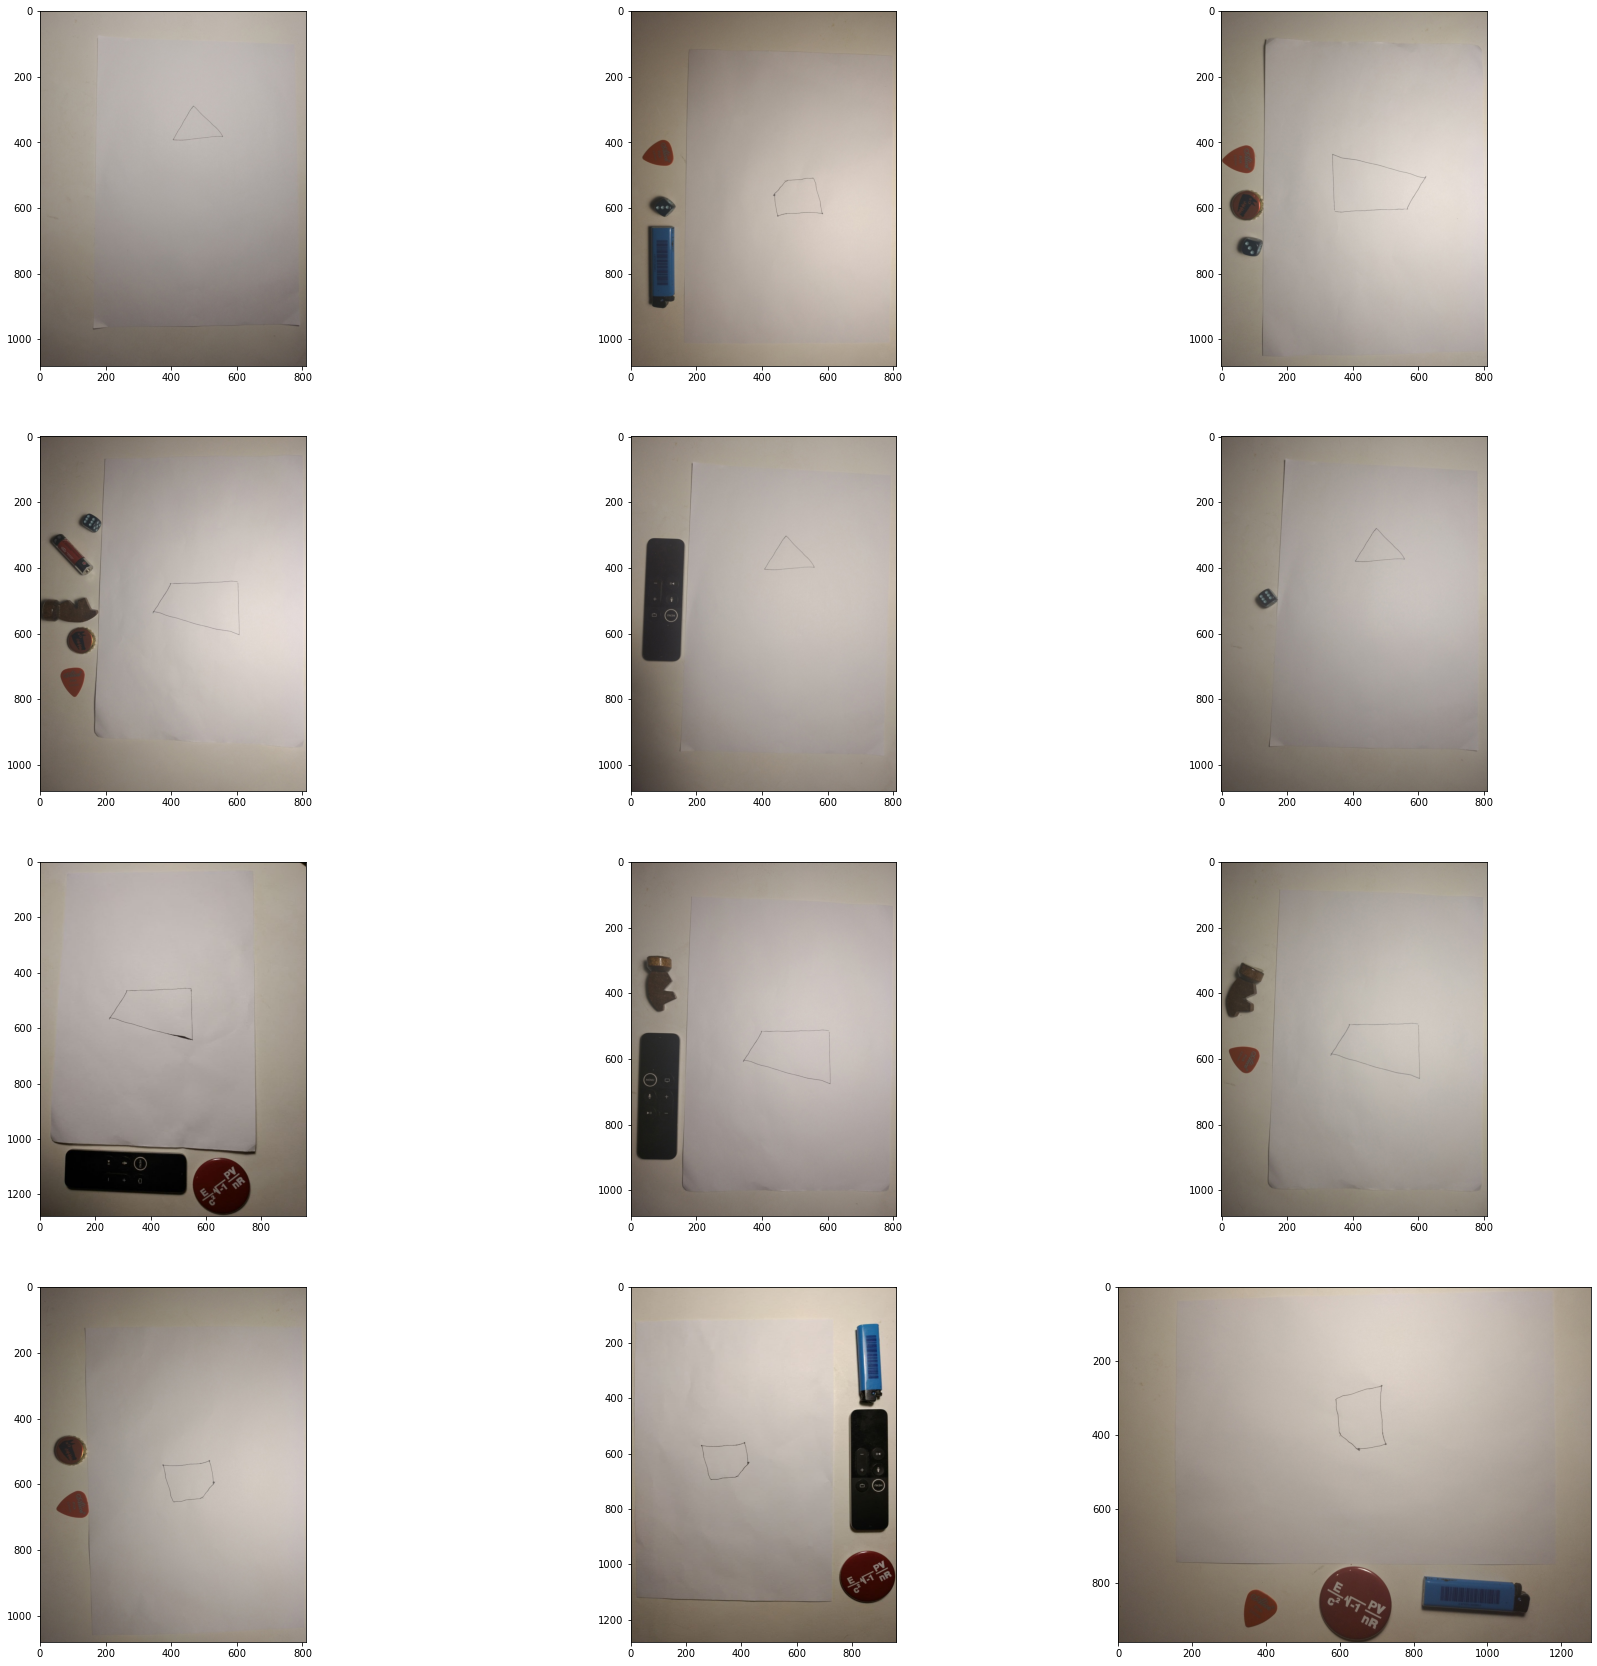

In [4]:
def show_example_data(data):
    fix, ax = plt.subplots(4,3, figsize=(30,30))
    for i, elem in enumerate(data):
        ax.flat[i].imshow(elem)
    


def get_example_data(show_data = False):
    example_data = []
    path = 'inputs_example'
    for file in os.listdir(path):
        img = imread(os.path.join(path, file))
#         print(img.shape)
        example_data.append(img)
    if show_data:
        show_example_data(example_data)
    return example_data

data = get_example_data(show_data = True)

Функция get_largest_area_boxes находит различные компоненты связанности на изображении, и сохраняет только те, у которых площадь больше 1200 пикселей.
Функция get_object_boxes делает маску изображения и подает на вход get_largest_area_boxes

Получим маску bbox с фигурами на изображении
[(1041, 89, 1203, 529), (1071, 552, 1276, 758)]


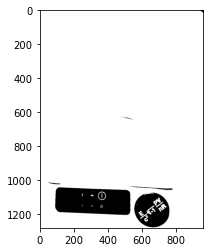

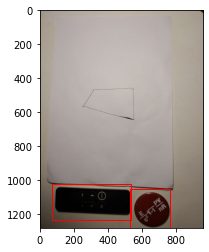

In [23]:
def get_largest_area_boxes(mask):
    result_boxes = []
    labels = sk_measure_label(~mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    for prop in props:
        if prop.area > 1200: # TODO ЭТо потенцияально зависящая от размеров изображения дырааааа.
            box = prop.bbox
            result_boxes.append(box)
    
    return result_boxes


def get_object_boxes(gray_img):
    upper_threshold = threshold_minimum(gray_img) # get only objects on image
    mask = gray_img >= upper_threshold 
    plt.imshow(mask, cmap = 'gray')
    return get_largest_area_boxes(mask) 

data = get_example_data(show_data = False)
print("Получим маску bbox с фигурами на изображении")
objects_boxes = get_object_boxes(rgb2gray(data[6]))
fig, ax = plt.subplots()
ax.imshow(data[6])
for box in objects_boxes:
    min_row, min_col, max_row, max_col = box
    ax.add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='r', facecolor='none'))
plt.show()

Данная фукнция get_object_and_figure_boxes, используя предыдущую находит на изображении bboxы объектов
Затем с помощью canny находит границы
И используя bboxы объектов закрашивает неинтересные области.

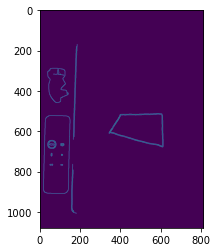

После покрытия боксами обхектов


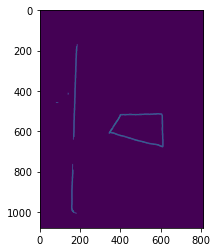

После обработки


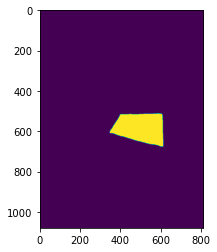

([(512, 345, 677, 609)], [(289, 39, 457, 137), (523, 16, 909, 148)])

In [31]:



def get_rect(x, y, width, height, angle): # from stackoverflow
    rect = np.array([(0, 0), (width, 0), (width, height), (0, height), (0, 0)])
    theta = (np.pi / 180.0) * angle
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    offset = np.array([x, y])
    transformed_rect = np.dot(rect, R) + offset
    return transformed_rect



def get_object_and_figure_boxes(main_img, show_info = False):
    
    gray_img = rgb2gray(main_img)

    objects_boxes = get_object_boxes(gray_img) # Get object bbox

    edges = canny(gray_img, sigma=1.5, low_threshold=0.1) 
    if show_info:
        plt.imshow(edges)
        plt.show()
    working_img = Image.fromarray(edges) 
    draw = ImageDraw.Draw(working_img)
    for box in objects_boxes: # paint black boxes where object bbox exist
        min_row, min_col, max_row, max_col = box
        rect = get_rect(max(min_col-20,0),max(min_row-20, 0), width=max_col- min_col+20, height= max_row - min_row + 20, angle=0)
        draw.polygon([tuple(p) for p in rect], fill=0)
    edges = np.asarray(working_img)
    if show_info:
    
        print("После покрытия боксами обхектов")
        plt.imshow(edges)
        plt.show()
    
    edges  = binary_closing(edges, selem=np.ones((4, 4)))
    my_edge_segmentation = binary_fill_holes(binary_closing(edges, selem=np.ones((7, 7))))
    my_edge_segmentation = binary_opening(my_edge_segmentation, selem=np.ones((10, 10)))
    if show_info:
    
        print("После обработки")
        plt.imshow(my_edge_segmentation)
        plt.show()
    edge_boxes = get_largest_area_boxes(~my_edge_segmentation)
    
    return edge_boxes,objects_boxes 


data = get_example_data()
get_object_and_figure_boxes(data[7],show_info = True)


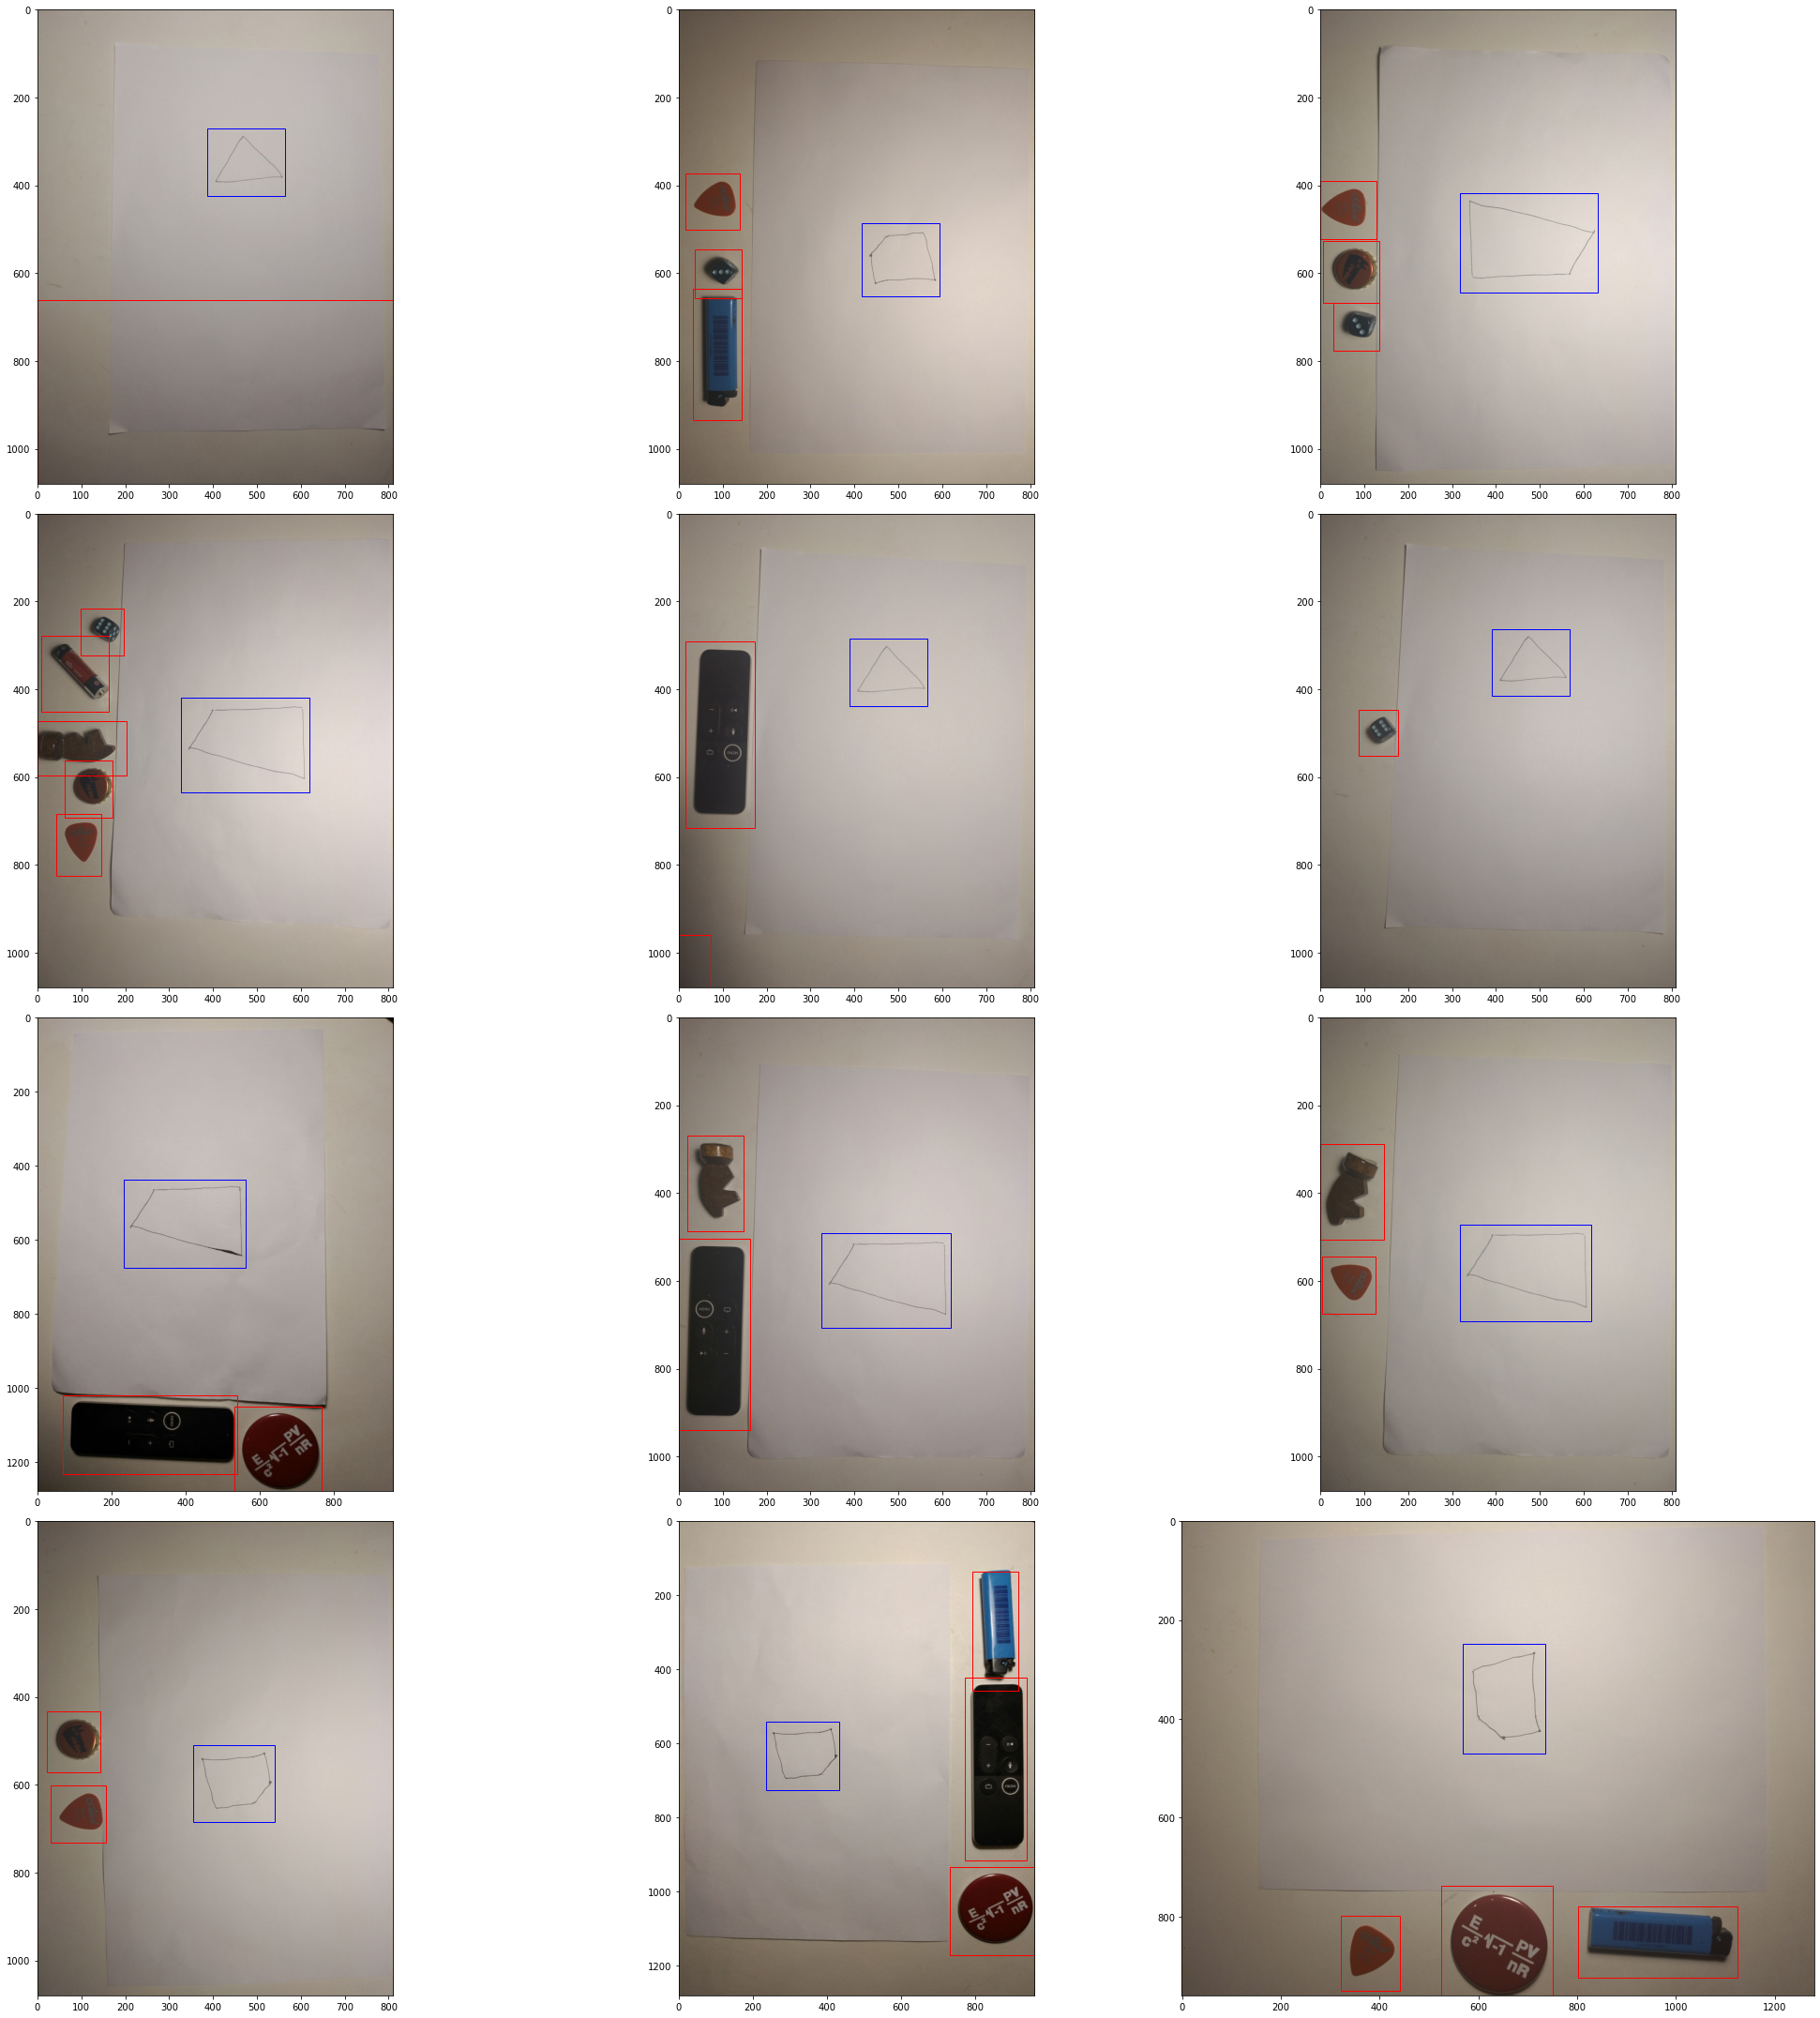

In [34]:
def get_bboxes_example_show(show_data = True, show_img = 12):
    data = get_example_data(show_data = show_data)
    
    fix, ax = plt.subplots(4,3, figsize=(30,30))

    for indx, main_img in enumerate(data):
        edge_boxes,  objects_boxes = get_object_and_figure_boxes(main_img)
        ax.flat[indx].imshow(main_img, cmap = "gray")
        for box in objects_boxes:
            min_row, min_col, max_row, max_col = box
            ax.flat[indx].add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='r', facecolor='none'))
        for box in edge_boxes:
            min_row, min_col, max_row, max_col = box
            ax.flat[indx].add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='b', facecolor='none'))
    fix.tight_layout()
    plt.show()
    
    
get_bboxes_example_show(show_data = False)

# Генерация тренировочных фоточек

In [ ]:
# Генерируем тренировочные наборы
cls_path  = 'classifyer_imgs'
path = "6"
cut_path = "6_cut"
data = get_path_data(os.path.join(cls_path, path))
print(len(data))
for indx, img in enumerate(data):
    plt.imshow(img)
    plt.show()
    objects_boxes  = get_object_boxes(rgb2gray(img))
    objects = cut_objects_from_image(img,objects_boxes)
    for j , obj in enumerate(objects):
#     plt.imshow(obj)
#     plt.show()
        imsave(os.path.join(cut_path, f"{indx}_{j}.jpg"),obj)
#     break

# Обучение классификатора

In [39]:
from sklearn.model_selection import train_test_split
def create_vector(size, elem):
    arr = np.zeros(size)
    arr[elem] = 1
    return arr

X = []
Y = []
cls_path  = 'classifyer_imgs'
folders = ['1_cut', "2_cut","3_cut" , "4_cut", "5_cut", "6_cut", "7_cut", "8_cut"]
indx_to_name  = {0:"Значок" , 1:"Пульт", 2:"Зажигалка", 3: "Медиатор", 4: "Шахматный конь", 5:"Крышка", 6: "Кубик", 7: "Батарейка"}
for indx, folder in enumerate(folders):
    for file in os.listdir(os.path.join(cls_path,folder)):
        img = imread(os.path.join(cls_path,folder, file))
        X.append(img)
        Y.append(create_vector(len(folders), indx))
        
        
# counter = dict()
from collections import Counter
counter = Counter()
for vector in Y:
    counter[np.argmax(vector)]+=1
    
print(counter)
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(Y), test_size=0.4, shuffle = True)
# print(np.array(X).shape)

Counter({1: 22, 2: 22, 4: 21, 0: 20, 6: 19, 3: 17, 5: 17, 7: 13})


In [40]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from keras import Model, Input
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Reshape, GlobalMaxPooling2D,
                          Activation)
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import BatchNormalization

def make_fashion_model(num_classes):
    imodel = Sequential()
    imodel.add(Reshape((128, 128, 3), input_shape=(128, 128, 3)))
    imodel.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    
    
    imodel.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(Flatten())

    iclf = Sequential()
    iclf.add(imodel)
    iclf.add(Dense(num_classes, activation='softmax'))

    iclf.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return iclf




In [41]:
from keras.preprocessing.image import ImageDataGenerator

# здесь следует изменить параметры аугментации:
aug = ImageDataGenerator(featurewise_center=False,
                   samplewise_center=False,
                   featurewise_std_normalization=False,
                   samplewise_std_normalization=False,
                   rotation_range= 60,
                   width_shift_range=0,
                   height_shift_range=0,
                   brightness_range=None,
                   shear_range = 0.0,
                   zoom_range=[0.9, 1.05],
                   channel_shift_range=0.0,
                   fill_mode='nearest',
                   cval=0.0,
                   horizontal_flip=False,
                   vertical_flip=False,
                   rescale=None)

In [48]:
batch_size = 4
fashion_clf = make_fashion_model(num_classes = len(folders))
train_X_train = X_train.copy()
# print(train_fashion_images.shape)
aug.fit(train_X_train)

gen = aug.flow(train_X_train, y_train,
               batch_size=batch_size)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist = fashion_clf.fit(gen,
               steps_per_epoch=len(train_X_train) // batch_size,
               epochs=50,
               validation_data=(X_test, y_test),callbacks=[model_checkpoint_callback])


Epoch 1/50
22/22 [==============================] - 3s 81ms/step - loss: 1.8878 - accuracy: 0.4535 - val_loss: 2.2979 - val_accuracy: 0.3115
Epoch 2/50
22/22 [==============================] - 2s 77ms/step - loss: 0.4584 - accuracy: 0.8605 - val_loss: 1.7044 - val_accuracy: 0.3607
Epoch 3/50
22/22 [==============================] - 2s 70ms/step - loss: 0.6198 - accuracy: 0.8023 - val_loss: 1.3637 - val_accuracy: 0.4754
Epoch 4/50
22/22 [==============================] - 2s 63ms/step - loss: 0.4446 - accuracy: 0.8140 - val_loss: 1.1525 - val_accuracy: 0.6393
Epoch 5/50
22/22 [==============================] - 1s 56ms/step - loss: 0.4014 - accuracy: 0.8605 - val_loss: 1.2631 - val_accuracy: 0.5738
Epoch 6/50
22/22 [==============================] - 1s 65ms/step - loss: 0.3271 - accuracy: 0.8953 - val_loss: 1.2216 - val_accuracy: 0.5738
Epoch 7/50
22/22 [==============================] - 2s 68ms/step - loss: 0.1390 - accuracy: 0.9535 - val_loss: 1.2462 - val_accuracy: 0.5902
Epoch 8/50
22

0.9508196711540222


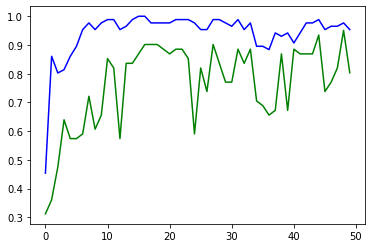

In [49]:

def plot_accuracy(history):
    acc = 'acc' if 'acc' in history else 'accuracy'
    val_acc = 'val_' + acc
    
    plt.plot(range(len(history[acc])), history[acc], color='b')
    plt.plot(range(len(history[val_acc])), history[val_acc], color='g')

    return hist.history[val_acc][-1]

plot_accuracy(hist.history)
print(max(hist.history['val_accuracy']))


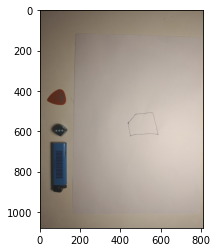

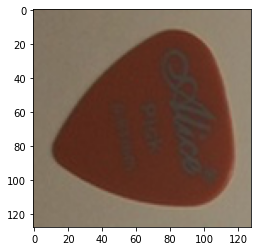

[1.0025086e-04 8.9574016e-08 2.7507232e-04 7.3753822e-01 1.0327916e-03
 2.6105356e-01 3.5566050e-08 3.6765869e-08] Медиатор


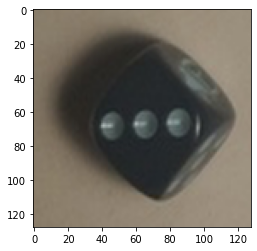

[1.0879940e-05 2.6840967e-01 7.4116566e-09 8.1729113e-06 7.1870929e-01
 3.2348118e-03 9.6267750e-03 3.3981613e-07] Шахматный конь


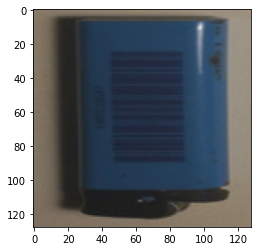

[2.0369585e-12 1.1936465e-16 1.0000000e+00 1.8657036e-11 6.8686954e-17
 1.5492627e-10 1.3256887e-09 4.1163514e-10] Зажигалка


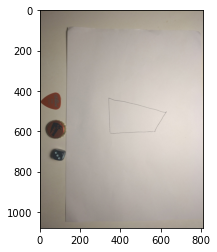

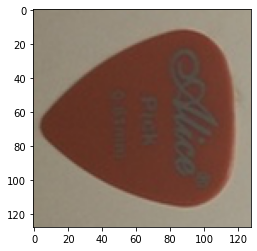

[1.5235681e-06 3.0108631e-09 1.2756418e-04 9.7706735e-01 5.7608664e-05
 2.2745959e-02 3.0297570e-10 1.3658978e-09] Медиатор


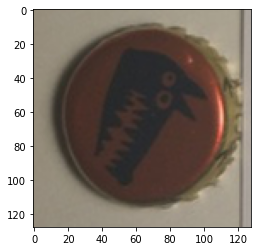

[7.6532024e-06 4.8017675e-01 9.9236445e-08 6.6359811e-05 1.0021419e-01
 4.1950217e-01 3.2049320e-05 7.3715648e-07] Пульт


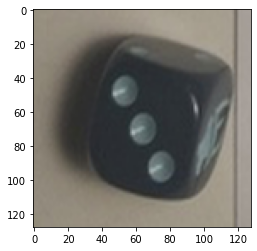

[1.0753649e-04 8.7690629e-02 1.2047184e-07 7.9316824e-06 2.2097634e-01
 1.2279859e-01 5.6841767e-01 1.1618521e-06] Кубик


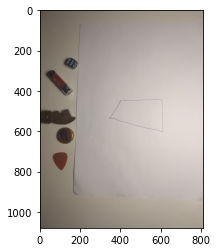

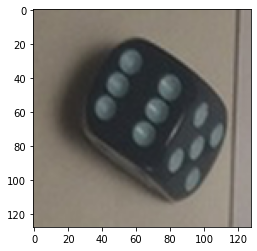

[1.1812262e-05 2.1223349e-02 2.5626059e-08 2.8735747e-05 1.4089517e-01
 9.6224481e-03 8.2821846e-01 3.7689102e-08] Кубик


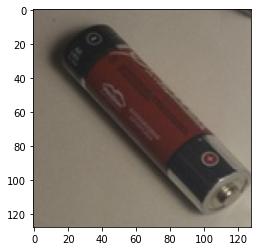

[8.63974839e-02 3.48893722e-04 2.04588985e-04 1.02824174e-01
 7.80066848e-01 2.15619281e-02 5.23674162e-03 3.35937482e-03] Шахматный конь


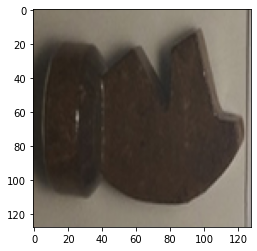

[5.0869025e-04 4.9556084e-03 9.2863690e-09 1.9100441e-06 9.8515421e-01
 9.2615718e-03 1.1734685e-04 5.6843203e-07] Шахматный конь


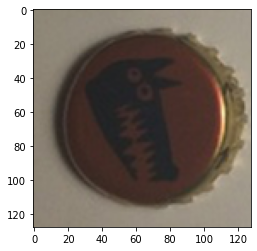

[1.2314483e-05 1.4978467e-01 5.5941264e-08 1.0924280e-05 5.4092550e-01
 3.0903226e-01 2.3171263e-04 2.5814602e-06] Шахматный конь


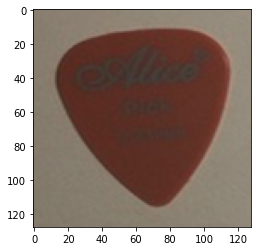

[6.2043994e-04 5.9534965e-08 2.6633597e-05 8.5881221e-01 2.8062318e-04
 1.4023522e-01 5.7978271e-09 2.4772218e-05] Медиатор


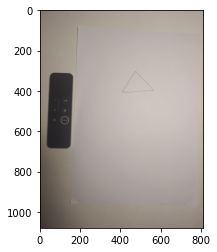

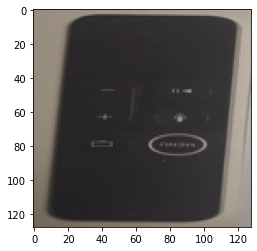

[6.6704117e-05 9.7231704e-01 1.6136736e-10 3.2220399e-07 2.7577961e-02
 9.0084171e-07 3.6411882e-05 5.7069855e-07] Пульт


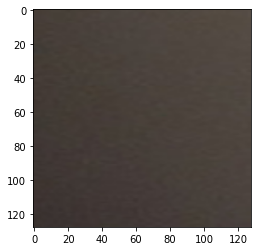

[6.0871053e-03 6.4921318e-05 1.1042040e-05 5.1583696e-02 9.3655449e-01
 2.0997159e-03 3.5987259e-03 4.1510268e-07] Шахматный конь


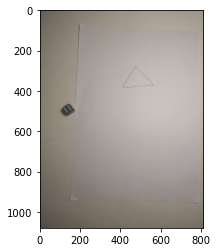

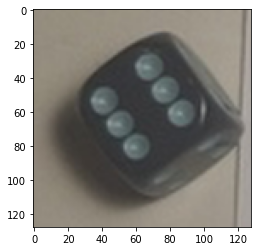

[3.4936427e-06 2.1459652e-02 6.4144231e-08 6.6101920e-06 9.3270904e-01
 3.2975215e-02 1.2845804e-02 2.2088653e-07] Шахматный конь


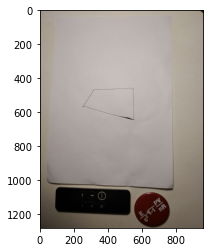

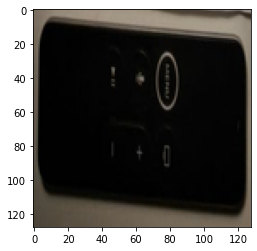

[1.5625327e-03 9.9481696e-01 3.4064070e-14 8.0649777e-08 3.6114610e-03
 7.8347296e-07 8.1035814e-06 3.7353210e-08] Пульт


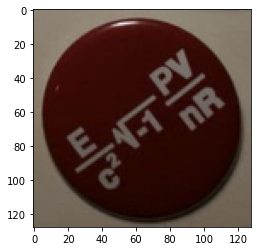

[9.9962759e-01 1.9956137e-04 1.4790404e-05 6.7688576e-05 6.7433461e-06
 4.5333411e-05 3.7819260e-05 5.1318801e-07] Значок


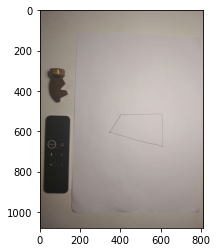

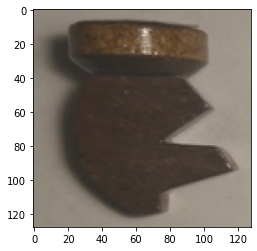

[8.4723779e-06 1.5554953e-01 5.1372323e-10 1.4172334e-05 8.4439975e-01
 2.5582340e-05 2.4845376e-06 3.7618971e-08] Шахматный конь


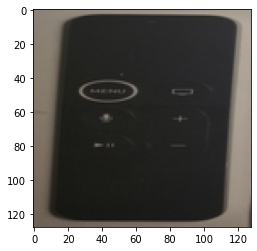

[3.0775680e-04 9.9933076e-01 5.1173132e-11 1.0111794e-09 3.3792623e-04
 2.2051923e-05 1.3651976e-06 2.6722020e-07] Пульт


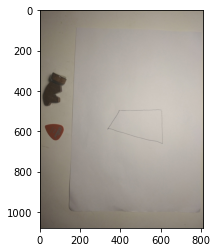

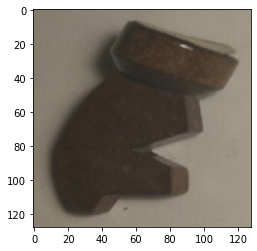

[1.2523408e-06 1.3557159e-03 1.8828039e-09 2.1574517e-05 9.9830377e-01
 3.1295459e-04 4.0629702e-06 5.7515587e-07] Шахматный конь


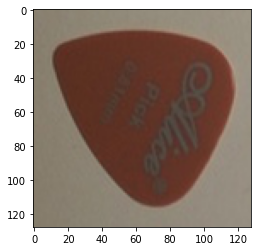

[1.4209661e-04 5.8451207e-08 5.1418215e-04 5.5141866e-01 5.2762753e-05
 4.4787201e-01 6.8913448e-09 2.0948538e-07] Медиатор


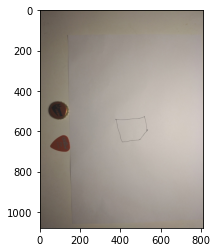

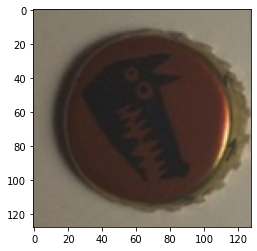

[1.0744985e-04 3.0134987e-02 1.6757613e-07 5.2904132e-05 8.4232181e-01
 1.2707713e-01 2.9871016e-04 6.9066587e-06] Шахматный конь


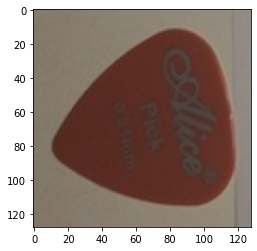

[1.5158307e-04 9.3819168e-08 2.8493923e-05 1.0594777e-01 7.3144925e-03
 8.8655740e-01 5.9140998e-08 1.0377737e-07] Крышка


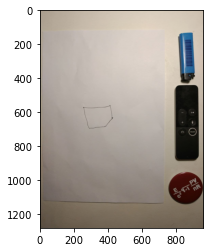

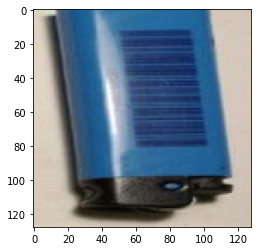

[3.3672197e-17 5.0331826e-19 1.0000000e+00 4.0250483e-21 9.8944766e-23
 1.8539042e-16 1.9527965e-14 9.6789206e-16] Зажигалка


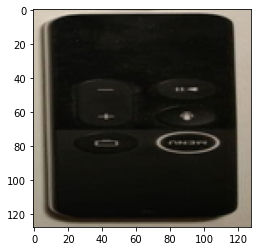

[1.8960185e-08 9.9999917e-01 1.3710666e-15 7.1345572e-14 8.1244076e-07
 3.8518494e-12 3.0083239e-10 4.0367634e-09] Пульт


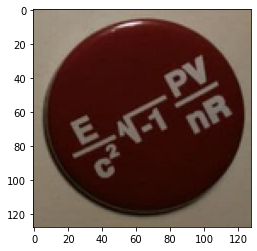

[9.9999535e-01 2.0467346e-06 1.9682373e-06 5.3508016e-09 4.5186910e-10
 2.3231820e-07 1.5798082e-07 1.7287606e-07] Значок


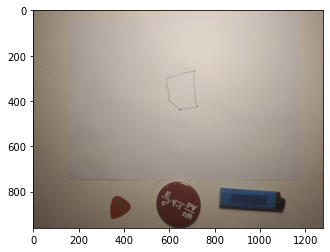

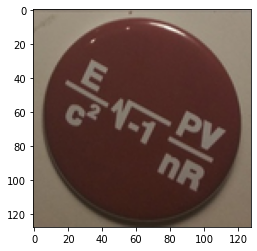

[8.2934225e-01 5.7028746e-08 1.8519760e-05 3.0573943e-08 9.6150892e-05
 1.0895363e-06 3.6121150e-05 1.7050567e-01] Значок


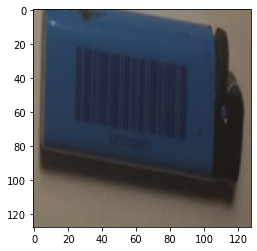

[1.8206398e-09 2.0783715e-09 9.6389318e-01 4.5569241e-08 2.4594147e-09
 9.5555173e-08 3.6106288e-02 4.0414889e-07] Зажигалка


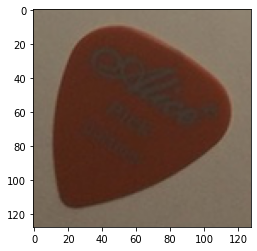

[1.1549718e-04 7.2339168e-07 5.4814614e-06 3.9798528e-02 8.7435514e-04
 9.5920444e-01 1.5820163e-07 9.1444934e-07] Крышка


In [50]:

fashion_clf.load_weights('best').expect_partial()
data = get_example_data()
datas = data[1:]
for img in datas:
    plt.imshow(img)
    plt.show()
    objects_boxes  = get_object_boxes(rgb2gray(img))
    objects = cut_objects_from_image(img, objects_boxes)
    res = fashion_clf.predict(np.array(objects))
    for indx, obj in enumerate(objects):
        plt.imshow(obj)
        plt.show()
        obj_indx = np.argmax(res[indx])
        print(res[indx], indx_to_name[obj_indx])
    #     res = fashion_clf.predict(obj)    



# Получение структуры фигуры

C:\Users\Admin\AppData\Local\Temp/ipykernel_2076/3889535284.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_img = rgb2gray(main_img)


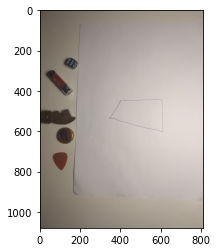

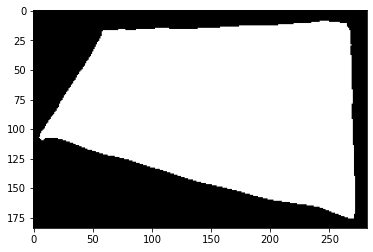

In [45]:
def cut_figure(img, edge_boxes):
    cut_figure = cut_objects_from_image(img, edge_boxes, resize = False)[0]
    edges = canny(rgb2gray(cut_figure), sigma=1.5, low_threshold=0.1) 
    figure = binary_fill_holes(binary_closing(edges, selem=np.ones((7, 7))))
    return figure


data = get_example_data()
img = data[3]
edge_boxes ,objects_boxes  = get_object_and_figure_boxes(rgb2gray(img))
plt.imshow(img)
plt.show()
figure = cut_figure(img,edge_boxes)
plt.imshow(figure, cmap = 'gray')


# Весь комлекс связанный с извлечением фигуры и классификацией

C:\Users\Admin\AppData\Local\Temp/ipykernel_2076/3889535284.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_img = rgb2gray(main_img)


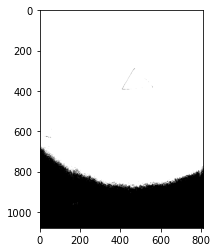

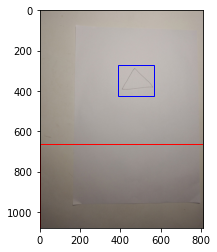

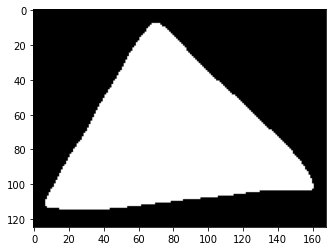

0.995 Медиатор


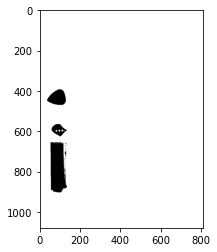

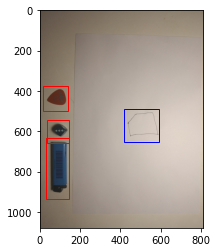

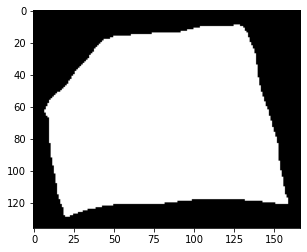

0.738 Медиатор
0.719 Шахматный конь
1.0 Зажигалка


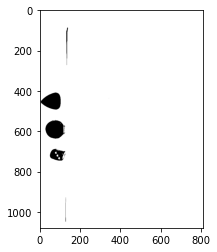

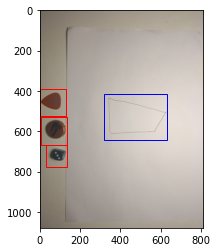

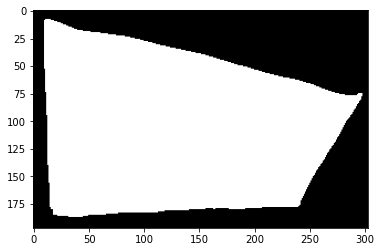

0.977 Медиатор
0.48 Пульт
0.568 Кубик


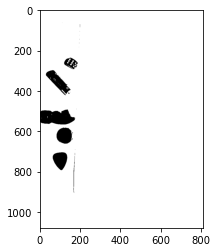

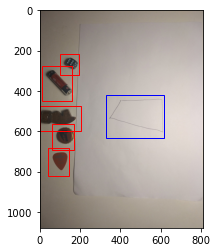

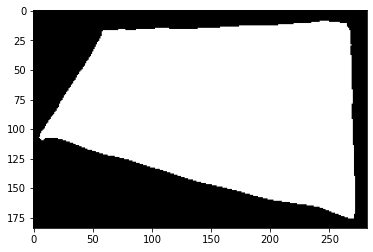

0.828 Кубик
0.78 Шахматный конь
0.985 Шахматный конь
0.541 Шахматный конь
0.859 Медиатор


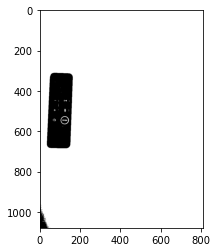

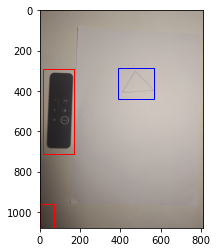

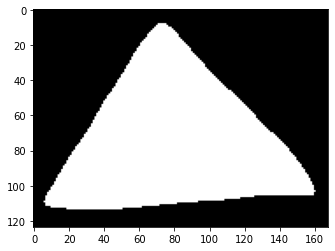

0.972 Пульт
0.937 Шахматный конь


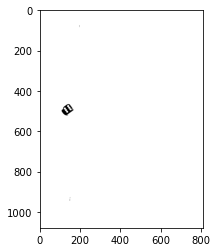

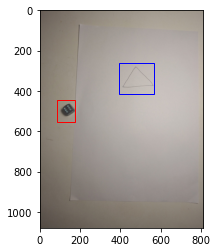

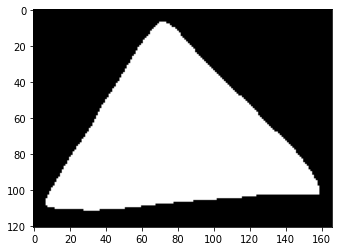

0.933 Шахматный конь


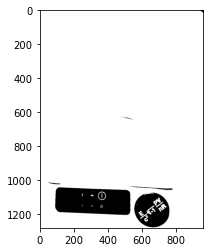

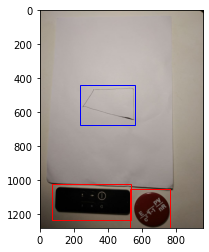

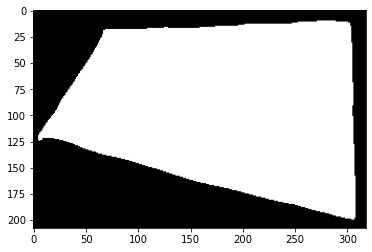

0.995 Пульт
1.0 Значок


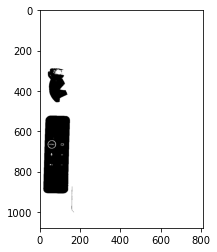

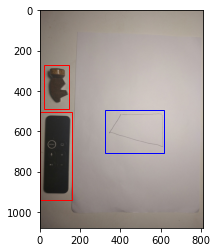

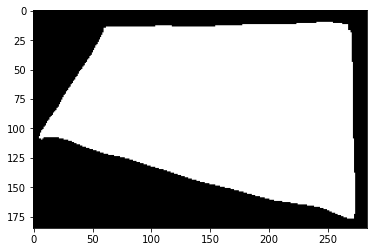

0.844 Шахматный конь
0.999 Пульт


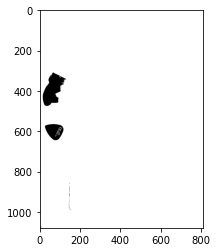

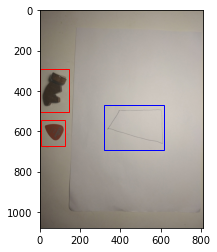

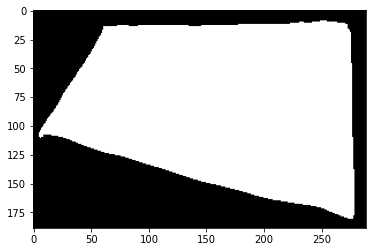

0.998 Шахматный конь
0.551 Медиатор


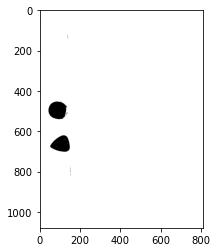

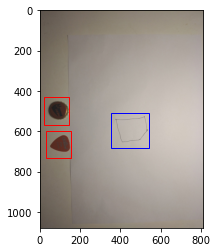

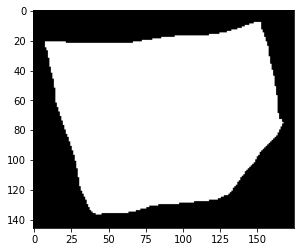

0.842 Шахматный конь
0.887 Крышка


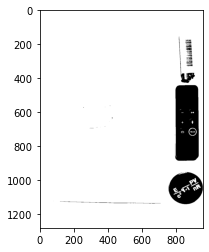

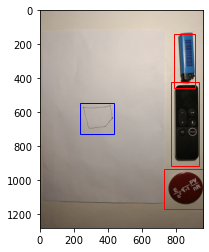

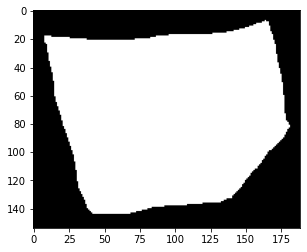

1.0 Зажигалка
1.0 Пульт
1.0 Значок


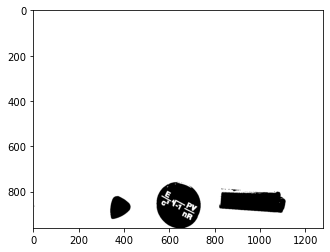

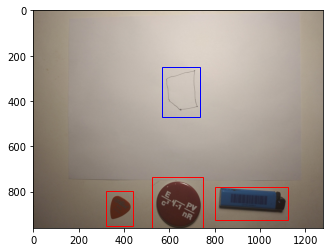

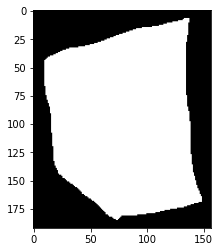

0.829 Значок
0.964 Зажигалка
0.959 Крышка


In [51]:

def classify_objects(cut_objects, classes = 8):
    model = make_fashion_model(num_classes = classes)
    model.load_weights('best').expect_partial()
    res = model.predict(np.array(cut_objects))
    return res

def extract_fig_and_objects(img, show_boxes = False):
    edge_boxes, objects_boxes  = get_object_and_figure_boxes(rgb2gray(img))
    if show_boxes:
        fig, ax = plt.subplots()
        ax.imshow(img)
        for box in objects_boxes:
            min_row, min_col, max_row, max_col = box
            ax.add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='r', facecolor='none'))
        #TODO ПРОВЕРКА ЧТО ФИГУРА ТОЛЬКО ОДНА
        for box in edge_boxes:
            min_row, min_col, max_row, max_col = box
            ax.add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='b', facecolor='none'))
        plt.show()
    cut_objects = cut_objects_from_image(img,objects_boxes)
    figure = cut_figure(img, edge_boxes)
    class_objects = classify_objects(cut_objects)
    return figure,edge_boxes[:2] ,class_objects



for elem in data:
#     plt.imshow(elem)
#     plt.show()
    figure, _, class_objects = extract_fig_and_objects(elem, show_boxes = True)
    plt.imshow(figure, cmap = 'gray')
    plt.show()
    for obj in class_objects:
        obj_indx = np.argmax(obj)
        print(round(obj[obj_indx],3), indx_to_name[obj_indx])









# Создание структур объектов
Мы классифицируем объекты, чтобы можно было воспользоваться уже созданной для них структурой

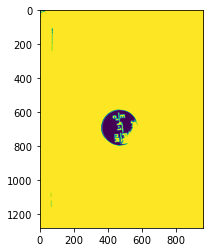

1


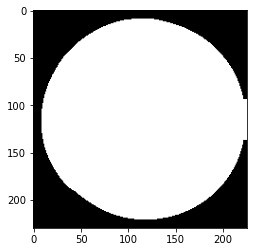

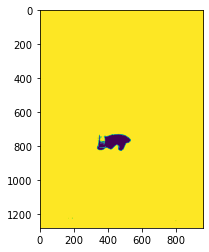

1


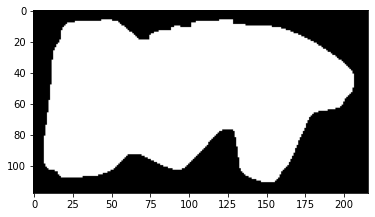

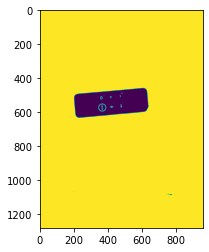

1


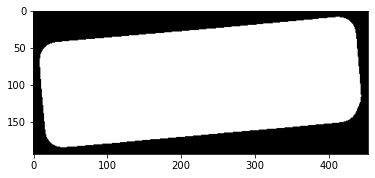

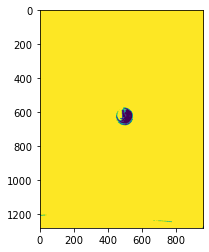

1


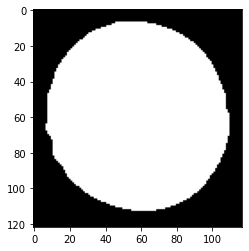

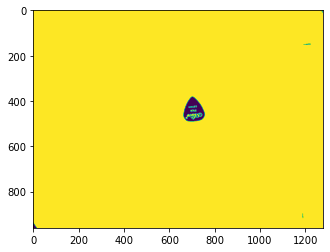

1


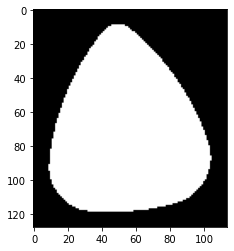

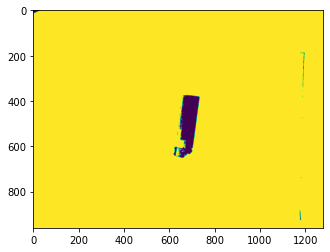

1


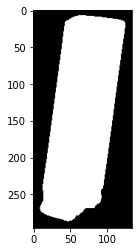

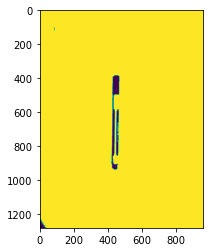

2


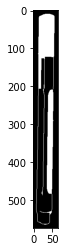

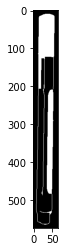

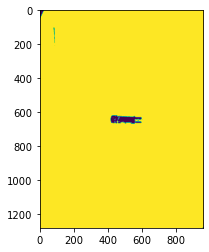

1


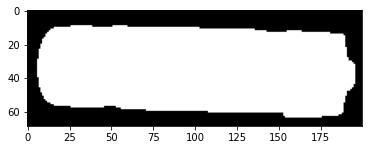

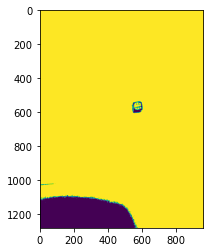

2


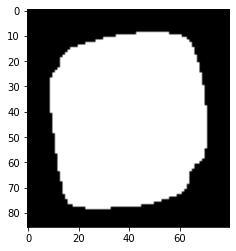

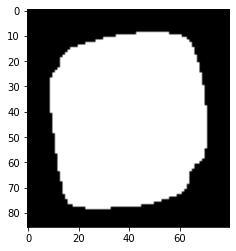

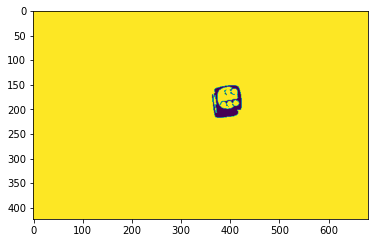

1


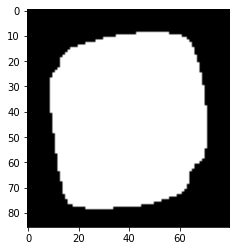

In [29]:
path = "imgs_for_structure"
save_path = "objects_figure"

for indx, file in enumerate(os.listdir(path)):
    img = imread(os.path.join(path, file))
    objects_boxes  = get_object_boxes(rgb2gray(img))
    for obj in objects_boxes:
        res = cut_figure(img , objects_boxes)
        plt.imshow(res, cmap = 'gray')
        plt.show()
        imsave(os.path.join(save_path,f"{indx}.jpg" ), 255 * res.astype("uint8"))

# Самая простая версия размещения одного в другое
Возьмем фотку, вытащим из нее фигуру на бумаге, классифицируем объекты, достанем их структуру.
И попробуем пихнуть.
И назовем это успехом и концом на сегодня

C:\Users\Admin\AppData\Local\Temp/ipykernel_2076/3889535284.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_img = rgb2gray(main_img)


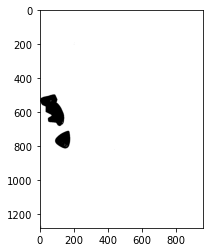

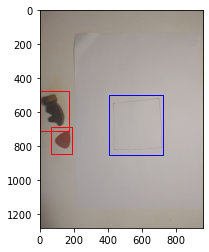

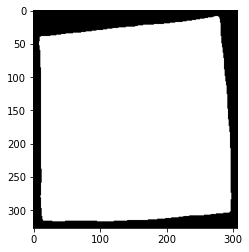

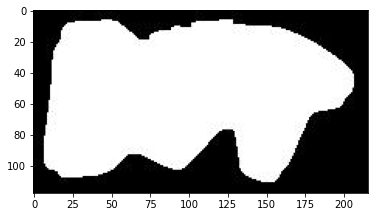

0.999 Шахматный конь


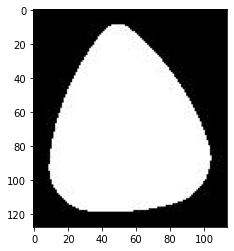

0.506 Медиатор
Промежуточный этап размещения


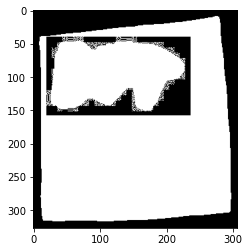

Промежуточный этап размещения


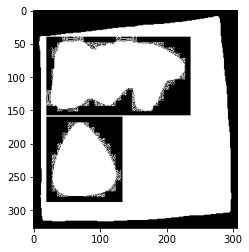

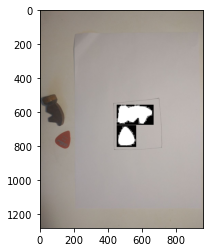

In [47]:
def slide_obj_over_fig(main_figure, obj, object_area):
    fig_y, fig_x = main_figure.shape
    obj_y, obj_x = obj.shape
    for pos_y in range(0, fig_y - obj_y, 20):
        for pos_x in range(0, fig_x - obj_x, 20):
            roi = main_figure[pos_y:pos_y+obj_y, pos_x:pos_x+obj_x].astype(int)
            intersect = cv.bitwise_and(roi,obj.astype(int))
            if np.sum(intersect) == object_area:
                main_figure[pos_y:pos_y+obj_y, pos_x:pos_x+obj_x] = obj.astype(bool)
                return (pos_y, pos_x), main_figure
                
    return (-1,-1), main_figure


path = 'work/easy_img.jpg'
figures = "objects_figure"
#  {0:"Значок" , 1:"Пульт", 2:"Зажигалка", 3: "Медиатор", 4: "Шахматный конь", 5:"Крышка", 6: "Кубик", 7: "Батарейка"}
figure_struct_paths =  {0:"0.jpg" , 1:"2.jpg", 2:"5.jpg", 3: "4.jpg", 4: "1.jpg", 5:"3.jpg", 6: "8.jpgк", 7: "7.jpg"}
img = imread(path)

figure, fig_location, class_objects = extract_fig_and_objects(img, show_boxes = True)


plt.imshow(figure, cmap = 'gray')
plt.show()
objects_structures = []
for obj in class_objects:
    obj_indx = np.argmax(obj)
    struct = imread(os.path.join(figures,figure_struct_paths[obj_indx]))
    plt.imshow(struct, cmap = 'gray')
    plt.show()
    struct = struct/255 > 0
    objects_structures.append(struct)
    print(round(obj[obj_indx],3), indx_to_name[obj_indx])

object_areas = []
for elem in objects_structures:
    area =  np.sum(elem)
    object_areas.append(area)


object_loc = []
for obj, area in zip(objects_structures,object_areas ):
    (y,x), figure = slide_obj_over_fig(figure, obj, area )
    
    object_loc.append([y,x])
    if x!= -1:
        print("Промежуточный этап размещения")
        plt.imshow(figure, cmap = 'gray')
        plt.show()
    else:
        print("nope")
        
for obj, location in zip(objects_structures,object_loc ):
    y_fig, x_fig, *_ =  fig_location[0]
    y, x = location
    obj_y, obj_x = obj.shape
    img[y_fig+y:y_fig+y+obj_y, x_fig+x:x_fig+x+obj_x, 0] = 255 * obj.astype(int)
    img[y_fig+y:y_fig+y+obj_y, x_fig+x:x_fig+x+obj_x, 1] = 255 * obj.astype(int)
    img[y_fig+y:y_fig+y+obj_y, x_fig+x:x_fig+x+obj_x, 2]  = 255 * obj.astype(int)
    
    
plt.imshow(img)